<a href="https://colab.research.google.com/github/barkhahbpp/melanoma/blob/main/melanoma_classifiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preparing Environment

## 0.1. Installing Required Libraries ##

In [22]:
!pip install gdown

## 0.2. Importing Libraries ##

In [23]:
# system
import os
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import progressbar
from google.colab import drive
# drive.mount('/content/drive')
import time

# image processing
import cv2 as cv
import skimage.io as io
from scipy import ndimage, signal, misc, spatial
from skimage import measure
from skimage.measure import label, regionprops, regionprops_table
from skimage.segmentation import mark_boundaries, slic_superpixels, slic
from skimage import color

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## 0.3. Local Function Library

### 0.3.1. Contrast Enhancement Functions

**CLAHE Contrast Enhancement**

In [24]:
def clahe_enhancement(I, clipLimit, tileGridSize):
  B,G,R = cv.split(img)

  clahe = cv.createCLAHE(clipLimit, tileGridSize)
  clR = clahe.apply(R)
  clG = clahe.apply(G)
  clB = clahe.apply(B)

  img_merge = cv.merge([clR, clG, clB])

  return img_merge

### 0.3.2. Morphological Descriptor Functions

**Crofton Perimeter**

In [25]:
def countIntercepts(I, h):
  B = np.abs(signal.convolve2d(I, h, mode='same'))
  n = np.sum(B)/2
  return n

def perimCrofton(segment_img):
  h = np.array([[-1,1]]);
  n1 = countIntercepts(segment_img,h)
  n2 = countIntercepts(segment_img, h.transpose())

  h = np.array([[1,0], [0,-1]])
  n3 = countIntercepts(segment_img, h.transpose())

  h = np.array([[0,1],[-1,0]])
  n4 = countIntercepts(segment_img, h.transpose())

  perim_Crofton = np.pi/4 * (n1+n2+ 1/np.sqrt(2)*(n3+n4))
  return perim_Crofton

**Feret Diameter**

In [26]:
def feretDiameter(segment_img):
  diameter = []
  for angle in range (180):
    I2 = ndimage.rotate(segment_img, angle, mode='nearest')
    I3 = I2.max(axis=0)

    diameter.append(np.sum(I3>0))

  return np.min(diameter), np.max(diameter), np.mean(diameter)

**Circularity**

In [27]:
def disk(t,r):
  x = np.arange(-t, t, 1)
  X,Y = np.meshgrid(x, x)

  I = (X**2+Y**2) <= r**2
  return I

def circularity(segment_img):
  P = perimCrofton(segment_img)
  print(f"Perimeter by Crofton: {P}")
  A = np.sum(segment_img)
  C = np.pi*4*A/P**2

  p = measure.perimeter(segment_img, neighbourhood=4)
  print(f"Usual perimeter: {p}")

  c = np.pi*4*A/p**2
  return C, c

**Convexity**

In [28]:
def convexity(segment_img):
  points = np.transpose(np.where(np.flip(segment_img,0)))
  hull = spatial.ConvexHull(points)

  A = np.sum(segment_img)
  Ah = hull.volume

  # plt.figure()
  # for simplex in hull.simplices:
  #   plt.plot(points[simplex, 1], points[simplex, 0],'k-')
  # plt.axis('equal')
  # plt.show()

  return A/Ah

**Region Properties**

In [29]:
def region_properties(segment_img):
  label_img = label(segment_img)
  regions = regionprops(label_img)

  return regions

### 0.3.3. Texture Descriptor Functions

**Local Binary Pattern (LBP)**

In [30]:
def LBP(img):
  """
  Local Binary Pattern of image I
  construct descriptor for each pixel, then evaluate histogram
  I: grayscale image (size nxm)
  """
  B = np.zeros(np.shape(img))

  code = np.array([[1, 2, 4], [8, 0, 16], [32, 64, 128]])

  # loop over all pixels except border pixels
  for i in np.arange(1, img.shape[0]-2):
    for j in np.arange(1, img.shape[1]-2):
      w = img[i-1:i+2, j-1:j+2]
      w = w >= img[i, j]
      w = w * code
      B[i, j] = np.sum(w)

  h, edges = np.histogram(B[1:-1, 1:-1], density=True, bins=256)
  return h, edges

**Histogram of Oriented Gradient**

In [31]:
def HOG(img):
  #(winSize - blockSize) % blockStride == 0
  img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  img_res = cv.resize(img_gray, (800, 800), interpolation=cv.INTER_CUBIC)

  win_size = img_res.shape
  cell_size = (20, 20)
  block_size = (200, 200)
  block_stride = (25, 25)
  num_bins = 9

  # # Set the parameters of the HOG descriptor using the variables defined above
  hog = cv.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

  # # Compute the HOG Descriptor for the gray scale image
  hog_descriptor = hog.compute(img_res)

  return hog_descriptor

**Generate Superpixel Image**

In [32]:
def super_segmentation(I, n_segments, compactness, sigma, start_label):
  segments = slic(I, n_segments=n_segments, compactness=compactness, sigma=sigma, start_label=start_label)
  superpixels = color.label2rgb(segments, I, kind='avg')

  return segments, superpixels

### 0.3.4. General Function ###

In [33]:
def segmen_mapping(I, segment_mask):
  R,G,B = cv.split(I)

  for i in range(len(B)):
    for j in range(len(B[i])):
      if segment_mask[i][j] == 0:
        B[i][j] = 0

  for i in range(len(G)):
    for j in range(len(G[i])):
      if segment_mask[i][j] == 0:
        G[i][j] = 0

  for i in range(len(R)):
    for j in range(len(R[i])):
      if segment_mask[i][j] == 0:
        R[i][j] = 0

  mapped_img = cv.merge([R, G, B])

  return mapped_img

# 1. Global Variable

In [34]:
global DATA_URL, GROUNDTRUTH_URL, IMAGE_URL, DATASET_DICT, GROUNDTRUTH_DF, DRIVE_URL
DATA_URL = f'https://raw.githubusercontent.com/barkhahbpp/melanoma/main/Project/'
GROUNDTRUTH_URL = DATA_URL+"GroundTruth_sorted.csv"
IMAGE_URL = DATA_URL+"PROJECT_Data/"
DATASET_DICT = {}
DRIVE_URL = '/content/drive/MyDrive/Colab Notebooks/melanomas/'

# 2. Dataset

## 2.1. Loading Ground Truth Data

In [35]:
GROUNDTRUTH_DF = pd.read_csv(GROUNDTRUTH_URL)
GROUNDTRUTH_DF.drop(GROUNDTRUTH_DF[GROUNDTRUTH_DF['state'] == 0].index, inplace=True)
GROUNDTRUTH_DF.reset_index(inplace=True)
GROUNDTRUTH_DF.drop(columns=GROUNDTRUTH_DF.columns[0], inplace=True)

In [36]:
GROUNDTRUTH_DF

,image_id,melanoma,seborrheic_keratosis,state
0,ISIC_0000000,0.0,0.0,1
1,ISIC_0000001,0.0,0.0,1
2,ISIC_0000002,1.0,0.0,1
3,ISIC_0000003,0.0,0.0,1
4,ISIC_0000004,1.0,0.0,1
...,...,...,...,...
195,ISIC_0000511,1.0,0.0,1
196,ISIC_0000513,1.0,0.0,1
197,ISIC_0000516,1.0,0.0,1
198,ISIC_0000517,1.0,0.0,1


In [37]:
GROUNDTRUTH_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image_id              200 non-null    object 
 1   melanoma              200 non-null    float64
 2   seborrheic_keratosis  200 non-null    float64
 3   state                 200 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.4+ KB


In [38]:
GROUNDTRUTH_DF[['melanoma', 'seborrheic_keratosis']] = GROUNDTRUTH_DF[['melanoma', 'seborrheic_keratosis']].astype(np.int64)

In [39]:
GROUNDTRUTH_DF.drop(columns=['state'], inplace=True)

In [40]:
GROUNDTRUTH_DF

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0,0
1,ISIC_0000001,0,0
2,ISIC_0000002,1,0
3,ISIC_0000003,0,0
4,ISIC_0000004,1,0
...,...,...,...
195,ISIC_0000511,1,0
196,ISIC_0000513,1,0
197,ISIC_0000516,1,0
198,ISIC_0000517,1,0


In [41]:
mela = GROUNDTRUTH_DF['melanoma'].value_counts()
mela

melanoma
0    100
1    100
Name: count, dtype: int64

In [42]:
imgs_idx = GROUNDTRUTH_DF['image_id'].values.tolist()
# imgs_idx = ["ISIC_0000000"]

## 2.2. Generating Features Dataset

In [43]:
# for idx in range(len(imgs_idx)):
bar = progressbar.ProgressBar()
for idx in bar(range(len(imgs_idx))):
  featurelist = []
  print(f" Generating Feature for Image index : {imgs_idx[idx]}")

  img = io.imread(IMAGE_URL+imgs_idx[idx]+".jpg")
  sgm_img = io.imread(IMAGE_URL+imgs_idx[idx]+"_segmentation.png")

  img = cv.resize(img, (800, 600), interpolation=cv.INTER_CUBIC)
  sgm_img = cv.resize(sgm_img, (800, 600), interpolation=cv.INTER_CUBIC)

  # Enhancing contrast Image
  img_enh = clahe_enhancement(I=img, clipLimit=2.0, tileGridSize=(8,8))

  # Mapping Segmentation to enhanced image
  img_mpd = segmen_mapping(img_enh, sgm_img)

  # Generating Superpixel Image from Mapped Image
  sgm_super, superpxl = super_segmentation(img_mpd, n_segments=1340, compactness=10, sigma=1, start_label=1)

  # Generating Morphological Descriptors

  region_props = region_properties(segment_img=sgm_img)
  crofton_perim = perimCrofton(segment_img=sgm_img)
  featurelist.append(crofton_perim)

  feret_min, feret_max, feret_mean = feretDiameter(sgm_img)
  featurelist.append(feret_min)
  featurelist.append(feret_max)
  featurelist.append(feret_mean)

  convex = convexity(sgm_img)
  featurelist.append(convex)

  featurelist.append(region_props[0].area)
  featurelist.extend(region_props[0].bbox)
  featurelist.extend(region_props[0].centroid)
  featurelist.append(region_props[0].orientation)
  featurelist.append(region_props[0].minor_axis_length)
  featurelist.append(region_props[0].major_axis_length)
  featurelist.append(region_props[0].eccentricity)
  featurelist.append(region_props[0].perimeter)
  featurelist.append(region_props[0].solidity)
  featurelist.append(region_props[0].equivalent_diameter)
  featurelist.append(region_props[0].extent)

  # Generating Texture Descriptors
  # LBP
  LBP_enh = LBP(img=img_enh)
  LBP_super = LBP(img=superpxl)

  featurelist.extend(LBP_enh[0])
  featurelist.extend(LBP_enh[1])
  featurelist.extend(LBP_super[0])
  featurelist.extend(LBP_super[1])

  # HOG
  # HOG_enh = HOG(img=img_enh)
  # featurelist.extend(HOG_enh)

  DATASET_DICT[imgs_idx[idx]] = featurelist


  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 Generating Feature for Image index : ISIC_0000000


  0% (1 of 200) |                        | Elapsed Time: 0:01:20 ETA:   4:26:00

 Generating Feature for Image index : ISIC_0000001


  1% (2 of 200) |                        | Elapsed Time: 0:02:14 ETA:   2:59:07

 Generating Feature for Image index : ISIC_0000002


  1% (3 of 200) |                        | Elapsed Time: 0:03:08 ETA:   2:58:42

 Generating Feature for Image index : ISIC_0000003


  2% (4 of 200) |                        | Elapsed Time: 0:03:59 ETA:   2:44:33

 Generating Feature for Image index : ISIC_0000004


  2% (5 of 200) |                        | Elapsed Time: 0:04:50 ETA:   2:45:32

 Generating Feature for Image index : ISIC_0000006


  3% (6 of 200) |                        | Elapsed Time: 0:05:43 ETA:   2:52:42

 Generating Feature for Image index : ISIC_0000007


  3% (7 of 200) |                        | Elapsed Time: 0:06:35 ETA:   2:48:06

 Generating Feature for Image index : ISIC_0000008


  4% (8 of 200) |                        | Elapsed Time: 0:07:27 ETA:   2:45:56

 Generating Feature for Image index : ISIC_0000009


  4% (9 of 200) |#                       | Elapsed Time: 0:08:17 ETA:   2:39:19

 Generating Feature for Image index : ISIC_0000010


  5% (10 of 200) |#                      | Elapsed Time: 0:09:13 ETA:   2:55:17

 Generating Feature for Image index : ISIC_0000011


  5% (11 of 200) |#                      | Elapsed Time: 0:10:03 ETA:   2:37:51

 Generating Feature for Image index : ISIC_0000012


  6% (12 of 200) |#                      | Elapsed Time: 0:10:59 ETA:   2:56:54

 Generating Feature for Image index : ISIC_0000013


  6% (13 of 200) |#                      | Elapsed Time: 0:11:49 ETA:   2:35:06

 Generating Feature for Image index : ISIC_0000014


  7% (14 of 200) |#                      | Elapsed Time: 0:12:41 ETA:   2:42:25

 Generating Feature for Image index : ISIC_0000015


  7% (15 of 200) |#                      | Elapsed Time: 0:13:31 ETA:   2:33:54

 Generating Feature for Image index : ISIC_0000016


  8% (16 of 200) |#                      | Elapsed Time: 0:14:24 ETA:   2:41:11

 Generating Feature for Image index : ISIC_0000017


  8% (17 of 200) |#                      | Elapsed Time: 0:15:14 ETA:   2:33:39

 Generating Feature for Image index : ISIC_0000018


  9% (18 of 200) |##                     | Elapsed Time: 0:16:06 ETA:   2:37:25

 Generating Feature for Image index : ISIC_0000019


  9% (19 of 200) |##                     | Elapsed Time: 0:16:57 ETA:   2:33:56

 Generating Feature for Image index : ISIC_0000020


 10% (20 of 200) |##                     | Elapsed Time: 0:17:47 ETA:   2:29:59

 Generating Feature for Image index : ISIC_0000021


 10% (21 of 200) |##                     | Elapsed Time: 0:18:40 ETA:   2:38:32

 Generating Feature for Image index : ISIC_0000022


 11% (22 of 200) |##                     | Elapsed Time: 0:19:32 ETA:   2:34:36

 Generating Feature for Image index : ISIC_0000023


 11% (23 of 200) |##                     | Elapsed Time: 0:20:27 ETA:   2:41:06

 Generating Feature for Image index : ISIC_0000024


 12% (24 of 200) |##                     | Elapsed Time: 0:21:18 ETA:   2:29:07

 Generating Feature for Image index : ISIC_0000025


 12% (25 of 200) |##                     | Elapsed Time: 0:22:11 ETA:   2:35:16

 Generating Feature for Image index : ISIC_0000026


 13% (26 of 200) |##                     | Elapsed Time: 0:23:02 ETA:   2:26:09

 Generating Feature for Image index : ISIC_0000027


 13% (27 of 200) |###                    | Elapsed Time: 0:23:54 ETA:   2:31:55

 Generating Feature for Image index : ISIC_0000028


 14% (28 of 200) |###                    | Elapsed Time: 0:24:45 ETA:   2:25:36

 Generating Feature for Image index : ISIC_0000029


 14% (29 of 200) |###                    | Elapsed Time: 0:25:35 ETA:   2:22:28

 Generating Feature for Image index : ISIC_0000030


 15% (30 of 200) |###                    | Elapsed Time: 0:26:27 ETA:   2:28:34

 Generating Feature for Image index : ISIC_0000031


 15% (31 of 200) |###                    | Elapsed Time: 0:27:18 ETA:   2:22:10

 Generating Feature for Image index : ISIC_0000032


 16% (32 of 200) |###                    | Elapsed Time: 0:28:11 ETA:   2:28:27

 Generating Feature for Image index : ISIC_0000034


 16% (33 of 200) |###                    | Elapsed Time: 0:29:02 ETA:   2:21:54

 Generating Feature for Image index : ISIC_0000035


 17% (34 of 200) |###                    | Elapsed Time: 0:29:54 ETA:   2:23:18

 Generating Feature for Image index : ISIC_0000036


 17% (35 of 200) |####                   | Elapsed Time: 0:30:45 ETA:   2:19:57

 Generating Feature for Image index : ISIC_0000037


 18% (36 of 200) |####                   | Elapsed Time: 0:31:35 ETA:   2:17:18

 Generating Feature for Image index : ISIC_0000038


 18% (37 of 200) |####                   | Elapsed Time: 0:32:28 ETA:   2:24:12

 Generating Feature for Image index : ISIC_0000039


 19% (38 of 200) |####                   | Elapsed Time: 0:33:19 ETA:   2:17:21

 Generating Feature for Image index : ISIC_0000040


 19% (39 of 200) |####                   | Elapsed Time: 0:34:12 ETA:   2:23:17

 Generating Feature for Image index : ISIC_0000041


 20% (40 of 200) |####                   | Elapsed Time: 0:35:06 ETA:   2:24:13

 Generating Feature for Image index : ISIC_0000042


 20% (41 of 200) |####                   | Elapsed Time: 0:35:58 ETA:   2:18:20

 Generating Feature for Image index : ISIC_0000043


 21% (42 of 200) |####                   | Elapsed Time: 0:36:49 ETA:   2:11:55

 Generating Feature for Image index : ISIC_0000044


 21% (43 of 200) |####                   | Elapsed Time: 0:37:41 ETA:   2:17:13

 Generating Feature for Image index : ISIC_0000045


 22% (44 of 200) |#####                  | Elapsed Time: 0:38:31 ETA:   2:11:04

 Generating Feature for Image index : ISIC_0000046


 22% (45 of 200) |#####                  | Elapsed Time: 0:39:21 ETA:   2:07:52

 Generating Feature for Image index : ISIC_0000047


 23% (46 of 200) |#####                  | Elapsed Time: 0:40:14 ETA:   2:15:18

 Generating Feature for Image index : ISIC_0000048


 23% (47 of 200) |#####                  | Elapsed Time: 0:41:05 ETA:   2:10:51

 Generating Feature for Image index : ISIC_0000049


 24% (48 of 200) |#####                  | Elapsed Time: 0:41:57 ETA:   2:12:41

 Generating Feature for Image index : ISIC_0000050


 24% (49 of 200) |#####                  | Elapsed Time: 0:42:48 ETA:   2:06:44

 Generating Feature for Image index : ISIC_0000051


 25% (50 of 200) |#####                  | Elapsed Time: 0:43:39 ETA:   2:07:10

 Generating Feature for Image index : ISIC_0000052


 25% (51 of 200) |#####                  | Elapsed Time: 0:44:30 ETA:   2:07:44

 Generating Feature for Image index : ISIC_0000053


 26% (52 of 200) |#####                  | Elapsed Time: 0:45:20 ETA:   2:03:45

 Generating Feature for Image index : ISIC_0000054


 26% (53 of 200) |######                 | Elapsed Time: 0:46:14 ETA:   2:11:12

 Generating Feature for Image index : ISIC_0000055


 27% (54 of 200) |######                 | Elapsed Time: 0:47:04 ETA:   2:02:11

 Generating Feature for Image index : ISIC_0000056


 27% (55 of 200) |######                 | Elapsed Time: 0:47:57 ETA:   2:08:00

 Generating Feature for Image index : ISIC_0000057


 28% (56 of 200) |######                 | Elapsed Time: 0:48:48 ETA:   2:01:38

 Generating Feature for Image index : ISIC_0000059


 28% (57 of 200) |######                 | Elapsed Time: 0:49:40 ETA:   2:05:16

 Generating Feature for Image index : ISIC_0000061


 29% (58 of 200) |######                 | Elapsed Time: 0:50:31 ETA:   2:00:28

 Generating Feature for Image index : ISIC_0000062


 29% (59 of 200) |######                 | Elapsed Time: 0:51:24 ETA:   2:04:54

 Generating Feature for Image index : ISIC_0000063


 30% (60 of 200) |######                 | Elapsed Time: 0:52:15 ETA:   1:58:16

 Generating Feature for Image index : ISIC_0000064


 30% (61 of 200) |#######                | Elapsed Time: 0:53:05 ETA:   1:55:37

 Generating Feature for Image index : ISIC_0000065


 31% (62 of 200) |#######                | Elapsed Time: 0:53:58 ETA:   2:01:42

 Generating Feature for Image index : ISIC_0000066


 31% (63 of 200) |#######                | Elapsed Time: 0:54:48 ETA:   1:54:40

 Generating Feature for Image index : ISIC_0000067


 32% (64 of 200) |#######                | Elapsed Time: 0:55:41 ETA:   1:59:00

 Generating Feature for Image index : ISIC_0000068


 32% (65 of 200) |#######                | Elapsed Time: 0:56:31 ETA:   1:53:28

 Generating Feature for Image index : ISIC_0000069


 33% (66 of 200) |#######                | Elapsed Time: 0:57:21 ETA:   1:52:14

 Generating Feature for Image index : ISIC_0000071


 33% (67 of 200) |#######                | Elapsed Time: 0:58:14 ETA:   1:57:34

 Generating Feature for Image index : ISIC_0000072


 34% (68 of 200) |#######                | Elapsed Time: 0:59:06 ETA:   1:53:47

 Generating Feature for Image index : ISIC_0000073


 34% (69 of 200) |#######                | Elapsed Time: 0:59:58 ETA:   1:54:14

 Generating Feature for Image index : ISIC_0000074


 35% (70 of 200) |########               | Elapsed Time: 1:00:48 ETA:   1:48:37

 Generating Feature for Image index : ISIC_0000075


 35% (71 of 200) |########               | Elapsed Time: 1:01:41 ETA:   1:53:11

 Generating Feature for Image index : ISIC_0000077


 36% (72 of 200) |########               | Elapsed Time: 1:02:31 ETA:   1:46:53

 Generating Feature for Image index : ISIC_0000078


 36% (73 of 200) |########               | Elapsed Time: 1:03:24 ETA:   1:50:50

 Generating Feature for Image index : ISIC_0000079


 37% (74 of 200) |########               | Elapsed Time: 1:04:16 ETA:   1:50:20

 Generating Feature for Image index : ISIC_0000080


 37% (75 of 200) |########               | Elapsed Time: 1:05:09 ETA:   1:50:23

 Generating Feature for Image index : ISIC_0000081


 38% (76 of 200) |########               | Elapsed Time: 1:06:06 ETA:   1:56:42

 Generating Feature for Image index : ISIC_0000082


 38% (77 of 200) |########               | Elapsed Time: 1:06:57 ETA:   1:46:16

 Generating Feature for Image index : ISIC_0000085


 39% (78 of 200) |########               | Elapsed Time: 1:07:50 ETA:   1:47:01

 Generating Feature for Image index : ISIC_0000086


 39% (79 of 200) |#########              | Elapsed Time: 1:08:42 ETA:   1:45:07

 Generating Feature for Image index : ISIC_0000087


 40% (80 of 200) |#########              | Elapsed Time: 1:09:32 ETA:   1:40:06

 Generating Feature for Image index : ISIC_0000088


 40% (81 of 200) |#########              | Elapsed Time: 1:10:25 ETA:   1:45:10

 Generating Feature for Image index : ISIC_0000089


 41% (82 of 200) |#########              | Elapsed Time: 1:11:16 ETA:   1:40:42

 Generating Feature for Image index : ISIC_0000091


 41% (83 of 200) |#########              | Elapsed Time: 1:12:10 ETA:   1:44:07

 Generating Feature for Image index : ISIC_0000092


 42% (84 of 200) |#########              | Elapsed Time: 1:13:01 ETA:   1:39:15

 Generating Feature for Image index : ISIC_0000093


 42% (85 of 200) |#########              | Elapsed Time: 1:13:56 ETA:   1:44:55

 Generating Feature for Image index : ISIC_0000094


 43% (86 of 200) |#########              | Elapsed Time: 1:14:51 ETA:   1:44:30

 Generating Feature for Image index : ISIC_0000095


 43% (87 of 200) |##########             | Elapsed Time: 1:15:44 ETA:   1:40:05

 Generating Feature for Image index : ISIC_0000096


 44% (88 of 200) |##########             | Elapsed Time: 1:16:35 ETA:   1:34:56

 Generating Feature for Image index : ISIC_0000097


 44% (89 of 200) |##########             | Elapsed Time: 1:17:28 ETA:   1:38:25

 Generating Feature for Image index : ISIC_0000098


 45% (90 of 200) |##########             | Elapsed Time: 1:18:28 ETA:   1:49:28

 Generating Feature for Image index : ISIC_0000099


 45% (91 of 200) |##########             | Elapsed Time: 1:19:17 ETA:   1:30:12

 Generating Feature for Image index : ISIC_0000100


 46% (92 of 200) |##########             | Elapsed Time: 1:20:11 ETA:   1:35:38

 Generating Feature for Image index : ISIC_0000101


 46% (93 of 200) |##########             | Elapsed Time: 1:21:01 ETA:   1:30:08

 Generating Feature for Image index : ISIC_0000102


 47% (94 of 200) |##########             | Elapsed Time: 1:22:01 ETA:   1:46:31

 Generating Feature for Image index : ISIC_0000103


 47% (95 of 200) |##########             | Elapsed Time: 1:22:54 ETA:   1:32:10

 Generating Feature for Image index : ISIC_0000104


 48% (96 of 200) |###########            | Elapsed Time: 1:23:46 ETA:   1:29:02

 Generating Feature for Image index : ISIC_0000105


 48% (97 of 200) |###########            | Elapsed Time: 1:24:41 ETA:   1:34:53

 Generating Feature for Image index : ISIC_0000107


 49% (98 of 200) |###########            | Elapsed Time: 1:25:32 ETA:   1:27:04

 Generating Feature for Image index : ISIC_0000108


 49% (99 of 200) |###########            | Elapsed Time: 1:26:24 ETA:   1:26:48

 Generating Feature for Image index : ISIC_0000109


 50% (100 of 200) |###########           | Elapsed Time: 1:27:15 ETA:   1:25:27

 Generating Feature for Image index : ISIC_0000110


 50% (101 of 200) |###########           | Elapsed Time: 1:28:06 ETA:   1:25:09

 Generating Feature for Image index : ISIC_0000111


 51% (102 of 200) |###########           | Elapsed Time: 1:28:58 ETA:   1:24:45

 Generating Feature for Image index : ISIC_0000112


 51% (103 of 200) |###########           | Elapsed Time: 1:29:49 ETA:   1:22:26

 Generating Feature for Image index : ISIC_0000113


 52% (104 of 200) |###########           | Elapsed Time: 1:30:43 ETA:   1:25:33

 Generating Feature for Image index : ISIC_0000116


 52% (105 of 200) |###########           | Elapsed Time: 1:31:33 ETA:   1:19:31

 Generating Feature for Image index : ISIC_0000118


 53% (106 of 200) |###########           | Elapsed Time: 1:32:28 ETA:   1:26:23

 Generating Feature for Image index : ISIC_0000119


 53% (107 of 200) |###########           | Elapsed Time: 1:33:19 ETA:   1:18:36

 Generating Feature for Image index : ISIC_0000120


 54% (108 of 200) |###########           | Elapsed Time: 1:34:12 ETA:   1:20:46

 Generating Feature for Image index : ISIC_0000121


 54% (109 of 200) |###########           | Elapsed Time: 1:35:02 ETA:   1:16:00

 Generating Feature for Image index : ISIC_0000122


 55% (110 of 200) |############          | Elapsed Time: 1:35:53 ETA:   1:17:29

 Generating Feature for Image index : ISIC_0000123


 55% (111 of 200) |############          | Elapsed Time: 1:36:45 ETA:   1:16:53

 Generating Feature for Image index : ISIC_0000124


 56% (112 of 200) |############          | Elapsed Time: 1:37:36 ETA:   1:13:46

 Generating Feature for Image index : ISIC_0000125


 56% (113 of 200) |############          | Elapsed Time: 1:38:40 ETA:   1:33:12

 Generating Feature for Image index : ISIC_0000126


 57% (114 of 200) |############          | Elapsed Time: 1:39:30 ETA:   1:12:40

 Generating Feature for Image index : ISIC_0000127


 57% (115 of 200) |############          | Elapsed Time: 1:40:20 ETA:   1:10:40

 Generating Feature for Image index : ISIC_0000128


 58% (116 of 200) |############          | Elapsed Time: 1:41:13 ETA:   1:13:47

 Generating Feature for Image index : ISIC_0000129


 58% (117 of 200) |############          | Elapsed Time: 1:42:06 ETA:   1:13:29

 Generating Feature for Image index : ISIC_0000130


 59% (118 of 200) |############          | Elapsed Time: 1:42:59 ETA:   1:11:28

 Generating Feature for Image index : ISIC_0000131


 59% (119 of 200) |#############         | Elapsed Time: 1:43:48 ETA:   1:07:19

 Generating Feature for Image index : ISIC_0000139


 60% (120 of 200) |#############         | Elapsed Time: 1:44:41 ETA:   1:10:30

 Generating Feature for Image index : ISIC_0000140


 60% (121 of 200) |#############         | Elapsed Time: 1:45:32 ETA:   1:06:12

 Generating Feature for Image index : ISIC_0000141


 61% (122 of 200) |#############         | Elapsed Time: 1:46:24 ETA:   1:08:43

 Generating Feature for Image index : ISIC_0000142


 61% (123 of 200) |#############         | Elapsed Time: 1:47:14 ETA:   1:04:12

 Generating Feature for Image index : ISIC_0000143


 62% (124 of 200) |#############         | Elapsed Time: 1:48:05 ETA:   1:04:35

 Generating Feature for Image index : ISIC_0000145


 62% (125 of 200) |#############         | Elapsed Time: 1:48:57 ETA:   1:04:30

 Generating Feature for Image index : ISIC_0000146


 63% (126 of 200) |#############         | Elapsed Time: 1:49:47 ETA:   1:02:11

 Generating Feature for Image index : ISIC_0000147


 63% (127 of 200) |#############         | Elapsed Time: 1:50:40 ETA:   1:03:48

 Generating Feature for Image index : ISIC_0000148


 64% (128 of 200) |##############        | Elapsed Time: 1:51:31 ETA:   1:00:53

 Generating Feature for Image index : ISIC_0000149


 64% (129 of 200) |##############        | Elapsed Time: 1:52:23 ETA:   1:01:51

 Generating Feature for Image index : ISIC_0000150


 65% (130 of 200) |##############        | Elapsed Time: 1:53:13 ETA:   0:58:56

 Generating Feature for Image index : ISIC_0000151


 65% (131 of 200) |##############        | Elapsed Time: 1:54:05 ETA:   0:59:16

 Generating Feature for Image index : ISIC_0000152


 66% (132 of 200) |##############        | Elapsed Time: 1:54:57 ETA:   0:58:25

 Generating Feature for Image index : ISIC_0000153


 66% (133 of 200) |##############        | Elapsed Time: 1:55:47 ETA:   0:55:46

 Generating Feature for Image index : ISIC_0000154


 67% (134 of 200) |##############        | Elapsed Time: 1:56:41 ETA:   1:00:24

 Generating Feature for Image index : ISIC_0000155


 67% (135 of 200) |##############        | Elapsed Time: 1:57:31 ETA:   0:53:43

 Generating Feature for Image index : ISIC_0000156


 68% (136 of 200) |##############        | Elapsed Time: 1:58:24 ETA:   0:56:35

 Generating Feature for Image index : ISIC_0000157


 68% (137 of 200) |###############       | Elapsed Time: 1:59:15 ETA:   0:53:08

 Generating Feature for Image index : ISIC_0000159


 69% (138 of 200) |###############       | Elapsed Time: 2:00:08 ETA:   0:55:24

 Generating Feature for Image index : ISIC_0000160


 69% (139 of 200) |###############       | Elapsed Time: 2:00:58 ETA:   0:50:59

 Generating Feature for Image index : ISIC_0000161


 70% (140 of 200) |###############       | Elapsed Time: 2:01:50 ETA:   0:52:01

 Generating Feature for Image index : ISIC_0000162


 70% (141 of 200) |###############       | Elapsed Time: 2:02:41 ETA:   0:49:25

 Generating Feature for Image index : ISIC_0000163


 71% (142 of 200) |###############       | Elapsed Time: 2:03:31 ETA:   0:48:53

 Generating Feature for Image index : ISIC_0000164


 71% (143 of 200) |###############       | Elapsed Time: 2:04:24 ETA:   0:49:58

 Generating Feature for Image index : ISIC_0000165


 72% (144 of 200) |###############       | Elapsed Time: 2:05:20 ETA:   0:52:46

 Generating Feature for Image index : ISIC_0000166


 72% (145 of 200) |###############       | Elapsed Time: 2:06:11 ETA:   0:46:06

 Generating Feature for Image index : ISIC_0000167


 73% (146 of 200) |################      | Elapsed Time: 2:07:01 ETA:   0:45:17

 Generating Feature for Image index : ISIC_0000169


 73% (147 of 200) |################      | Elapsed Time: 2:07:53 ETA:   0:46:08

 Generating Feature for Image index : ISIC_0000171


 74% (148 of 200) |################      | Elapsed Time: 2:08:44 ETA:   0:43:37

 Generating Feature for Image index : ISIC_0000172


 74% (149 of 200) |################      | Elapsed Time: 2:09:37 ETA:   0:45:09

 Generating Feature for Image index : ISIC_0000174


 75% (150 of 200) |################      | Elapsed Time: 2:10:28 ETA:   0:42:43

 Generating Feature for Image index : ISIC_0000176


 75% (151 of 200) |################      | Elapsed Time: 2:11:22 ETA:   0:44:16

 Generating Feature for Image index : ISIC_0000276


 76% (152 of 200) |################      | Elapsed Time: 2:12:13 ETA:   0:40:16

 Generating Feature for Image index : ISIC_0000277


 76% (153 of 200) |################      | Elapsed Time: 2:13:04 ETA:   0:40:27

 Generating Feature for Image index : ISIC_0000278


 77% (154 of 200) |################      | Elapsed Time: 2:13:55 ETA:   0:38:59

 Generating Feature for Image index : ISIC_0000281


 77% (155 of 200) |#################     | Elapsed Time: 2:14:45 ETA:   0:37:37

 Generating Feature for Image index : ISIC_0000282


 78% (156 of 200) |#################     | Elapsed Time: 2:15:38 ETA:   0:38:37

 Generating Feature for Image index : ISIC_0000283


 78% (157 of 200) |#################     | Elapsed Time: 2:16:28 ETA:   0:36:08

 Generating Feature for Image index : ISIC_0000285


 79% (158 of 200) |#################     | Elapsed Time: 2:17:21 ETA:   0:36:32

 Generating Feature for Image index : ISIC_0000288


 79% (159 of 200) |#################     | Elapsed Time: 2:18:10 ETA:   0:33:58

 Generating Feature for Image index : ISIC_0000289


 80% (160 of 200) |#################     | Elapsed Time: 2:19:00 ETA:   0:32:57

 Generating Feature for Image index : ISIC_0000290


 80% (161 of 200) |#################     | Elapsed Time: 2:19:53 ETA:   0:34:28

 Generating Feature for Image index : ISIC_0000292


 81% (162 of 200) |#################     | Elapsed Time: 2:20:43 ETA:   0:31:33

 Generating Feature for Image index : ISIC_0000293


 81% (163 of 200) |#################     | Elapsed Time: 2:21:32 ETA:   0:30:32

 Generating Feature for Image index : ISIC_0000294


 82% (164 of 200) |##################    | Elapsed Time: 2:22:24 ETA:   0:31:00

 Generating Feature for Image index : ISIC_0000295


 82% (165 of 200) |##################    | Elapsed Time: 2:23:14 ETA:   0:29:09

 Generating Feature for Image index : ISIC_0000297


 83% (166 of 200) |##################    | Elapsed Time: 2:24:09 ETA:   0:31:25

 Generating Feature for Image index : ISIC_0000298


 83% (167 of 200) |##################    | Elapsed Time: 2:25:04 ETA:   0:29:52

 Generating Feature for Image index : ISIC_0000299


 84% (168 of 200) |##################    | Elapsed Time: 2:25:55 ETA:   0:27:11

 Generating Feature for Image index : ISIC_0000300


 84% (169 of 200) |##################    | Elapsed Time: 2:26:45 ETA:   0:26:01

 Generating Feature for Image index : ISIC_0000301


 85% (170 of 200) |##################    | Elapsed Time: 2:27:38 ETA:   0:26:23

 Generating Feature for Image index : ISIC_0000302


 85% (171 of 200) |##################    | Elapsed Time: 2:28:29 ETA:   0:24:33

 Generating Feature for Image index : ISIC_0000303


 86% (172 of 200) |##################    | Elapsed Time: 2:29:18 ETA:   0:23:07

 Generating Feature for Image index : ISIC_0000306


 86% (173 of 200) |###################   | Elapsed Time: 2:30:11 ETA:   0:23:54

 Generating Feature for Image index : ISIC_0000307


 87% (174 of 200) |###################   | Elapsed Time: 2:31:01 ETA:   0:21:31

 Generating Feature for Image index : ISIC_0000310


 87% (175 of 200) |###################   | Elapsed Time: 2:31:54 ETA:   0:21:58

 Generating Feature for Image index : ISIC_0000311


 88% (176 of 200) |###################   | Elapsed Time: 2:32:44 ETA:   0:20:03

 Generating Feature for Image index : ISIC_0000313


 88% (177 of 200) |###################   | Elapsed Time: 2:33:37 ETA:   0:20:14

 Generating Feature for Image index : ISIC_0000314


 89% (178 of 200) |###################   | Elapsed Time: 2:34:27 ETA:   0:18:36

 Generating Feature for Image index : ISIC_0000390


 89% (179 of 200) |###################   | Elapsed Time: 2:35:17 ETA:   0:17:33

 Generating Feature for Image index : ISIC_0000393


 90% (180 of 200) |###################   | Elapsed Time: 2:36:10 ETA:   0:17:24

 Generating Feature for Image index : ISIC_0000395


 90% (181 of 200) |###################   | Elapsed Time: 2:37:00 ETA:   0:15:51

 Generating Feature for Image index : ISIC_0000410


 91% (182 of 200) |####################  | Elapsed Time: 2:37:53 ETA:   0:15:51

 Generating Feature for Image index : ISIC_0000412


 91% (183 of 200) |####################  | Elapsed Time: 2:38:43 ETA:   0:14:16

 Generating Feature for Image index : ISIC_0000413


 92% (184 of 200) |####################  | Elapsed Time: 2:39:34 ETA:   0:13:36

 Generating Feature for Image index : ISIC_0000415


 92% (185 of 200) |####################  | Elapsed Time: 2:40:25 ETA:   0:12:39

 Generating Feature for Image index : ISIC_0000420


 93% (186 of 200) |####################  | Elapsed Time: 2:41:15 ETA:   0:11:39

 Generating Feature for Image index : ISIC_0000434


 93% (187 of 200) |####################  | Elapsed Time: 2:42:08 ETA:   0:11:27

 Generating Feature for Image index : ISIC_0000444


 94% (188 of 200) |####################  | Elapsed Time: 2:42:59 ETA:   0:10:12

 Generating Feature for Image index : ISIC_0000445


 94% (189 of 200) |####################  | Elapsed Time: 2:43:53 ETA:   0:09:55

 Generating Feature for Image index : ISIC_0000463


 95% (190 of 200) |####################  | Elapsed Time: 2:44:43 ETA:   0:08:20

 Generating Feature for Image index : ISIC_0000466


 95% (191 of 200) |##################### | Elapsed Time: 2:45:36 ETA:   0:08:00

 Generating Feature for Image index : ISIC_0000469


 96% (192 of 200) |##################### | Elapsed Time: 2:46:27 ETA:   0:06:47

 Generating Feature for Image index : ISIC_0000482


 96% (193 of 200) |##################### | Elapsed Time: 2:47:20 ETA:   0:06:08

 Generating Feature for Image index : ISIC_0000484


 97% (194 of 200) |##################### | Elapsed Time: 2:48:10 ETA:   0:05:02

 Generating Feature for Image index : ISIC_0000487


 97% (195 of 200) |##################### | Elapsed Time: 2:49:02 ETA:   0:04:18

 Generating Feature for Image index : ISIC_0000511


 98% (196 of 200) |##################### | Elapsed Time: 2:49:52 ETA:   0:03:22

 Generating Feature for Image index : ISIC_0000513


 98% (197 of 200) |##################### | Elapsed Time: 2:50:43 ETA:   0:02:30

 Generating Feature for Image index : ISIC_0000516


 99% (198 of 200) |##################### | Elapsed Time: 2:51:36 ETA:   0:01:46

 Generating Feature for Image index : ISIC_0000517


 99% (199 of 200) |##################### | Elapsed Time: 2:52:26 ETA:   0:00:49

 Generating Feature for Image index : ISIC_0000518


100% (200 of 200) |######################| Elapsed Time: 2:53:19 Time:  2:53:19


In [44]:
feature_df = pd.DataFrame.from_dict(DATASET_DICT, orient="index")

feature_df

,0,1,2,3,4,5,6,7,8,9,...,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045
ISIC_0000000,495919.815270,452,686,577.366667,245.703803,52,36,504,37,556,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0
ISIC_0000001,204492.846855,197,236,222.500000,233.988977,1,180,371,181,372,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0
ISIC_0000002,463932.490688,394,512,467.244444,231.608873,1,106,351,107,352,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0
ISIC_0000003,419433.096627,441,512,478.355556,242.146828,1,40,456,41,457,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0
ISIC_0000004,385777.139263,400,537,481.294444,249.320960,1,44,390,45,391,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0000511,713184.771241,526,762,634.350000,219.827169,2,15,311,17,313,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0
ISIC_0000513,359513.332783,353,497,434.016667,240.403324,1,124,354,125,355,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0
ISIC_0000516,472966.359429,383,675,547.716667,232.744550,1,69,224,70,225,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0
ISIC_0000517,653247.740708,600,968,852.011111,228.936564,1,0,4,1,5,...,738.105469,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0


In [45]:
gt_df = pd.DataFrame({'melanoma': GROUNDTRUTH_DF['melanoma'].values.tolist()}, index=GROUNDTRUTH_DF['image_id'])
final_df = pd.concat([feature_df, gt_df['melanoma']], axis=1)

In [46]:
final_df.to_csv("final_df.csv")

## 2.3. Loading Feature Dataset

In [47]:
import gdown

if not os.path.exists('final_df.csv'):
  url = 'https://drive.google.com/uc?id=1Wksiis4ZwPitGyaJCInmAlVJIq4FN8ws'
  output = 'final_df.csv'
  gdown.download(url, output, quiet=False)

In [48]:
start = time.time()
chunk_sz = 20
chunk_df = pd.read_csv("final_df.csv",chunksize=chunk_sz)

end = time.time()
print("Read csv with chunks: ",(end-start),"sec")

final_df = pd.concat(chunk_df)

Read csv with chunks:  0.005629301071166992 sec


In [49]:
final_df.index = final_df['Unnamed: 0']
final_df.drop(columns=['Unnamed: 0'], inplace=True)
final_df.index.names = ["image_id"]

In [50]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,1037,1038,1039,1040,1041,1042,1043,1044,1045,melanoma
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0000000,495919.815270,452,686,577.366667,245.703803,52,36,504,37,556,...,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0,0
ISIC_0000001,204492.846855,197,236,222.500000,233.988977,1,180,371,181,372,...,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0,0
ISIC_0000002,463932.490688,394,512,467.244444,231.608873,1,106,351,107,352,...,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0,1
ISIC_0000003,419433.096627,441,512,478.355556,242.146828,1,40,456,41,457,...,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0,0
ISIC_0000004,385777.139263,400,537,481.294444,249.320960,1,44,390,45,391,...,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0000511,713184.771241,526,762,634.350000,219.827169,2,15,311,17,313,...,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0,1
ISIC_0000513,359513.332783,353,497,434.016667,240.403324,1,124,354,125,355,...,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0,1
ISIC_0000516,472966.359429,383,675,547.716667,232.744550,1,69,224,70,225,...,741.09375,744.082031,747.070312,750.058594,753.046875,756.035156,759.023438,762.011719,765.0,1


# 3. Support Vector Machine

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import LearningCurveDisplay, learning_curve

## 3.1. Splitting Dataset

In [52]:
# Splitting Train vs Test Dataset
X = final_df.drop(columns=['melanoma'])
y = final_df['melanoma']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3.2. Model and Training ##

In [53]:
svc = make_pipeline(StandardScaler(),
                    SVC(kernel="poly",
                        C=100, gamma="auto",
                        degree=3,
                        coef0=1,
                        verbose=True, probability=True))

In [54]:
svc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=100, coef0=1, gamma='auto', kernel='poly',
                     probability=True, verbose=True))])

In [55]:
classify = svc.fit(X_train, y_train)
pred = svc.predict(X_test)

[LibSVM]

## 3.2. Evaluation ##

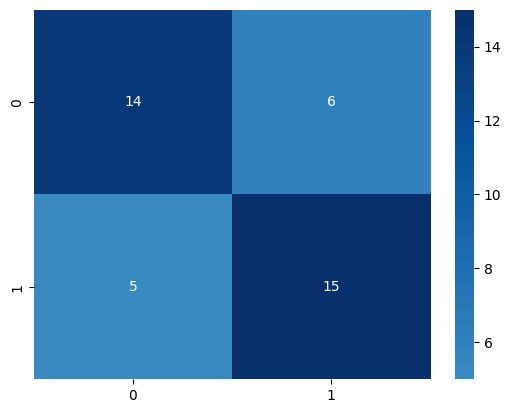

In [56]:
confusion = confusion_matrix(y_test, pred)
sns.heatmap(confusion, annot=True, center=0.5, cmap='Blues')
plt.show()

In [57]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72        20
           1       0.71      0.75      0.73        20

    accuracy                           0.73        40
   macro avg       0.73      0.72      0.72        40
weighted avg       0.73      0.72      0.72        40



In [58]:
pred_prod = svc.predict_proba(X_test)[:,1]

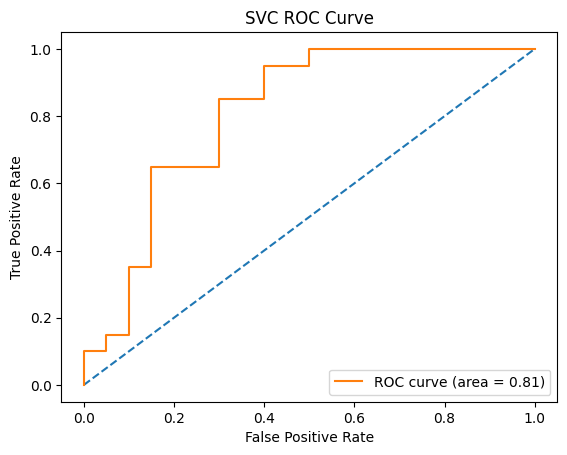

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prod)
roc_auc = metrics.auc(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel(r'False Positive Rate')
plt.ylabel(r'True Positive Rate')
plt.title('SVC ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 4. Stochastic Gradient Descent

In [60]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler

## 4.1. Splitting Dataset ##

In [61]:
# Splitting Train vs Test Dataset
X = final_df.drop(columns=['melanoma'])
y = final_df['melanoma']

scaler = StandardScaler()
X = scaler.fit_transform(X=X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4.2. Model and Training

In [62]:
# SGD = make_pipeline(StandardScaler(),
#                     SGDClassifier(max_iter=1000, tol=1e-3, verbose=True))
SGD = SGDClassifier(max_iter=1000, verbose=True)
calibrated_clf = CalibratedClassifierCV(SGD, cv=5)

In [63]:
calibrated_clf

CalibratedClassifierCV(cv=5, estimator=SGDClassifier(verbose=True))

In [64]:
model=calibrated_clf.fit(X_train, y_train)
pred = model.predict(X_test)

-- Epoch 1
Norm: 760.52, NNZs: 515, Bias: -45.780311, T: 128, Avg. loss: 592.778605
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 893.20, NNZs: 515, Bias: 5.670096, T: 256, Avg. loss: 368.725078
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 962.10, NNZs: 515, Bias: 18.880384, T: 384, Avg. loss: 233.377741
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 1023.45, NNZs: 515, Bias: 18.782184, T: 512, Avg. loss: 120.963643
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 1091.16, NNZs: 515, Bias: 18.182899, T: 640, Avg. loss: 141.031357
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 1050.39, NNZs: 515, Bias: 6.513523, T: 768, Avg. loss: 82.637852
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 1021.04, NNZs: 515, Bias: -9.918659, T: 896, Avg. loss: 22.527155
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 992.36, NNZs: 515, Bias: 5.544518, T: 1024, Avg. loss: 56.653413
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 966.55, NNZs: 515, Bias: 0.782747, T: 1

## 4.3. Evaluation

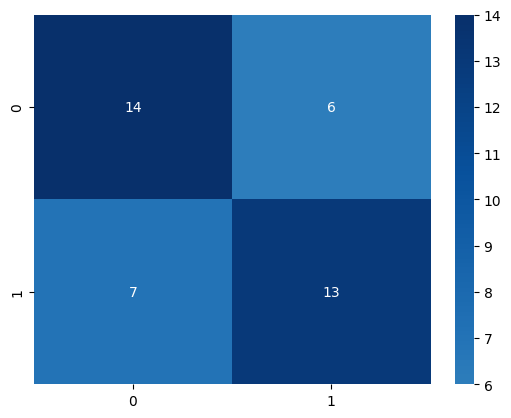

In [65]:
confusion = confusion_matrix(y_test, pred)
sns.heatmap(confusion, annot=True, center=0.5, cmap='Blues')
plt.show()

In [66]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.68      0.65      0.67        20

    accuracy                           0.68        40
   macro avg       0.68      0.68      0.67        40
weighted avg       0.68      0.68      0.67        40



In [67]:
# calibrator = CalibratedClassifierCV(SGD, cv='prefit')
pred_prob = calibrated_clf.predict_proba(X_test)[:,1]
pred_prob

array([0.85772954, 0.67894279, 0.78983213, 0.80281703, 0.29421521,
       0.45157911, 0.24015691, 0.77528286, 0.83242921, 0.32117208,
       0.73396627, 0.75629694, 0.16966314, 0.64749445, 0.1452981 ,
       0.3762914 , 0.78192881, 0.19172351, 0.35769133, 0.39931972,
       0.16994439, 0.43615319, 0.25377572, 0.27620063, 0.61484809,
       0.48875384, 0.22284529, 0.67075731, 0.50415698, 0.54773671,
       0.75110207, 0.59672234, 0.19457301, 0.50788573, 0.76152831,
       0.32605899, 0.31671743, 0.18892399, 0.67067599, 0.34798421])

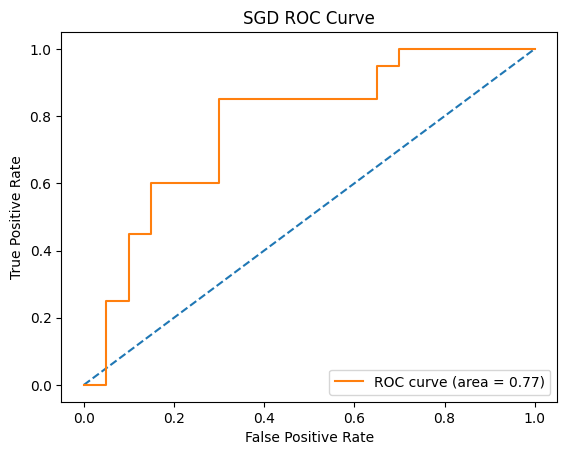

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel(r'False Positive Rate')
plt.ylabel(r'True Positive Rate')
plt.title('SGD ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 5. Artificial Neural Network #

## 5.1. Splitting Dataset ##

In [69]:
# Splitting Train vs Test Dataset
X = final_df.drop(columns=['melanoma'])
y = final_df['melanoma']

# Data Normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(X=X)

# Split into training and remaining (validation + test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14, stratify=y)

# Further split remaining into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=14, stratify=y_test)

## 5.2. Model ANN ##

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras import optimizers

In [71]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.7),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                67008     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 68065 (265.88 KB)
Trainable params: 68065 (265.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


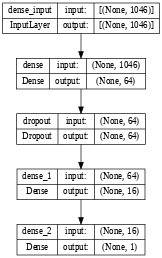

In [72]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=48)

In [73]:
METRICS = [
      tf.keras.metrics.AUC(name='AUC'),
      "accuracy"
]

initial_rate = 0.0001
end_rate = 1e-8
decay_steps = 10000

learning_rate_fn = optimizers.schedules.PolynomialDecay(
    initial_rate,
    decay_steps,
    end_rate,
    power=0.5)

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=METRICS)

model.compile(loss='binary_crossentropy',
              # optimizer=SGD(learning_rate=initial_rate, momentum=0.9),
              optimizer=Adam(learning_rate=initial_rate),
              metrics=METRICS)

## 5.3. Training Model

In [74]:
# prompt: Training model please

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=50,
                    epochs=1000,
                    verbose=2)


Epoch 1/1000
3/3 - 2s - loss: 0.7538 - AUC: 0.4887 - accuracy: 0.5071 - val_loss: 0.6912 - val_AUC: 0.5356 - val_accuracy: 0.5333 - 2s/epoch - 605ms/step
Epoch 2/1000
3/3 - 0s - loss: 0.7522 - AUC: 0.5046 - accuracy: 0.4857 - val_loss: 0.6906 - val_AUC: 0.5311 - val_accuracy: 0.5667 - 78ms/epoch - 26ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.7339 - AUC: 0.5103 - accuracy: 0.4143 - val_loss: 0.6898 - val_AUC: 0.5333 - val_accuracy: 0.5333 - 76ms/epoch - 25ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.7041 - AUC: 0.5859 - accuracy: 0.4929 - val_loss: 0.6886 - val_AUC: 0.5356 - val_accuracy: 0.5667 - 66ms/epoch - 22ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.6953 - AUC: 0.6027 - accuracy: 0.5071 - val_loss: 0.6866 - val_AUC: 0.5889 - val_accuracy: 0.5333 - 75ms/epoch - 25ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.6875 - AUC: 0.6110 - accuracy: 0.5429 - val_loss: 0.6852 - val_AUC: 0.5889 - val_accuracy: 0.5667 - 86ms/epoch - 29ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.7146 - AUC: 0.5342 - accuracy: 0.5143 -

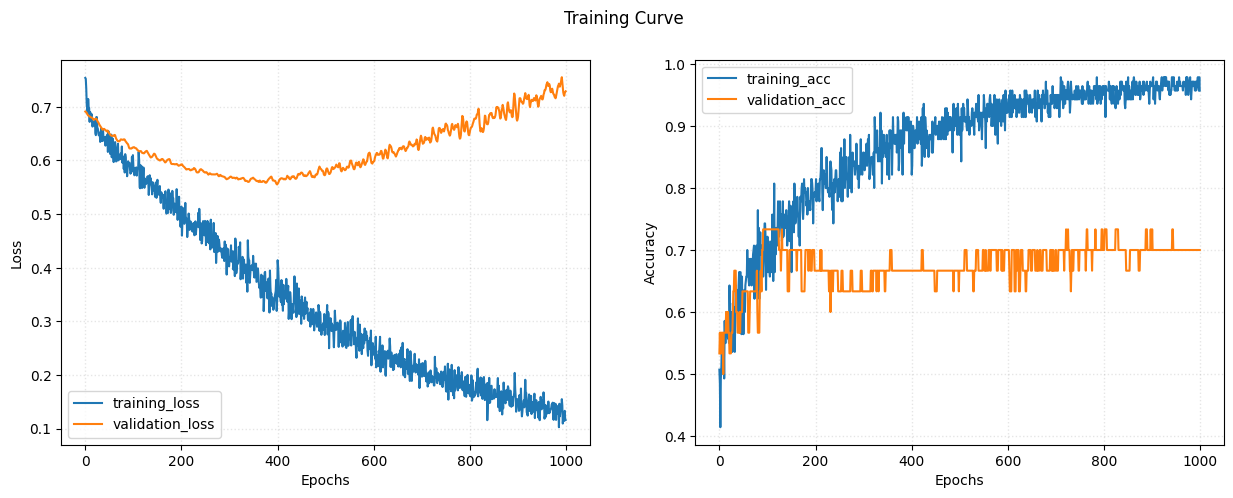

In [75]:
fig, (axs1, axs2) = plt.subplots(1,2,figsize=(15,5))

loss = {
    'training_loss': history.history['loss'],
    'validation_loss': history.history['val_loss']
}

auc = {
    'training_acc': history.history['accuracy'],
    'validation_acc': history.history['val_accuracy']
}

axs1.plot(loss['training_loss'], label=list(loss.keys())[0])
axs1.plot(loss['validation_loss'], label=list(loss.keys())[1])
axs1.grid(color='grey', linestyle=':', linewidth=1, alpha=0.2)
axs1.legend()

axs2.plot(auc['training_acc'], label=list(auc.keys())[0])
axs2.plot(auc['validation_acc'], label=list(auc.keys())[1])
axs2.grid(color='grey', linestyle=':', linewidth=1, alpha=0.2)
axs2.legend()

axs1.set_xlabel('Epochs')
axs1.set_ylabel('Loss')
axs2.set_xlabel('Epochs')
axs2.set_ylabel('Accuracy')

fig.suptitle("Training Curve")

plt.show()

In [84]:
evaluate = model.evaluate(X_test, y_test)

print(f"Loss : {evaluate[0]:.2f}, AUC : {evaluate[1]:.2f}, Accuracy :{evaluate[2]:.2f}")

1/1 [==============================] - 0s 93ms/step - loss: 0.6355 - AUC: 0.8200 - accuracy: 0.7667
Loss : 0.64, AUC : 0.82, Accuracy :0.77


## 5.4. Evaluation

In [85]:
pred = model.predict(X_test)
pred

1/1 [==============================] - 0s 82ms/step


array([[0.06744277],
       [0.9996207 ],
       [0.6521207 ],
       [0.14386457],
       [0.04021712],
       [0.9946307 ],
       [0.97085303],
       [0.04281243],
       [0.7679365 ],
       [0.5937767 ],
       [0.9932401 ],
       [0.17344579],
       [0.03820955],
       [0.7827871 ],
       [0.01569549],
       [0.12718785],
       [0.9377799 ],
       [0.75250566],
       [0.99777114],
       [0.03183027],
       [0.9975113 ],
       [0.9674553 ],
       [0.38460937],
       [0.06526174],
       [0.9887456 ],
       [0.09834696],
       [0.12706578],
       [0.05193546],
       [0.9781174 ],
       [0.867967  ]], dtype=float32)

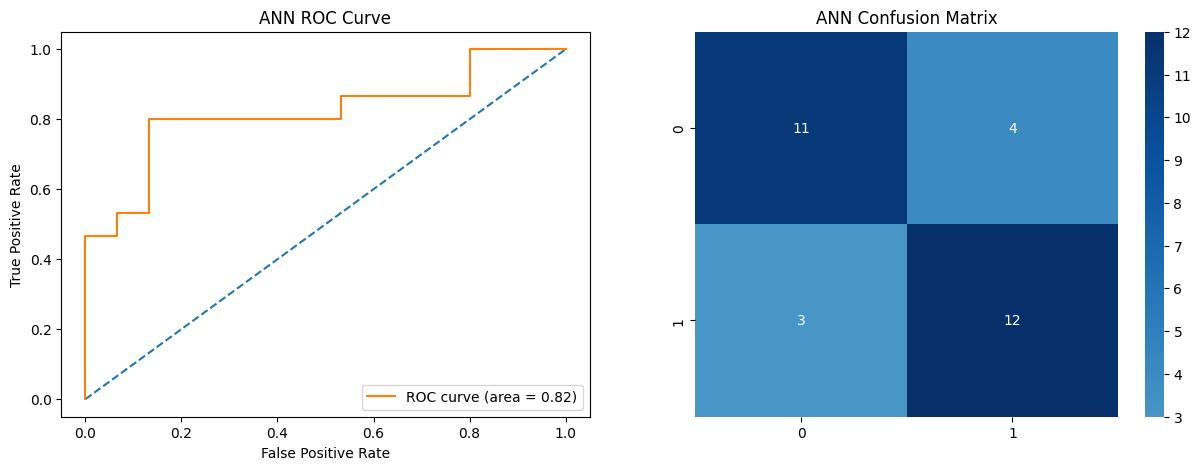

In [86]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
ax1.plot([0,1], [0,1], '--')
ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.set_xlabel(r'False Positive Rate')
ax1.set_ylabel(r'True Positive Rate')
ax1.set_title('ANN ROC Curve')
ax1.legend(loc="lower right")

pred = np.squeeze(pred)
pred = np.array([1 if x > 0.5 else 0 for x in pred])

confusion = confusion_matrix(y_test, pred)
sns.heatmap(confusion, annot=True, center=0.5, cmap='Blues', ax=ax2)
ax2.set_title('ANN Confusion Matrix')

plt.show()

In [87]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.75      0.80      0.77        15

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.77        30
weighted avg       0.77      0.77      0.77        30

